In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import collections
import json
from matplotlib import pyplot as plt
import scipy.linalg as la
from sklearn.cluster import KMeans

In [0]:
with open('/content/drive/My Drive/data/daily_price_t.json') as json_file:
    json_data = json.load(json_file)
price_s = pd.read_json(json_data)

with open('/content/drive/My Drive/data/fg_sector_bfff_t.json') as json_file:
    json_data = json.load(json_file)
industry_fg = pd.read_json(json_data)

In [0]:
#No biased에 대한 결과가 요정도..
def draw_pnl(input_pnl, index_list) :
    draw_data = pd.Series(input_pnl)
    draw_data.index = index_list
    plt.figure(figsize=(10,5))
    plt.plot(draw_data)
    plt.grid(b = True)
    return draw_data


"""
industry_list와 채워진 matrix set을 받으면 loading matrix 로 변환
loading matrix 출력 예시
#loading_m= industry_dic[industry_list[0]]

"""
def make_loading_matrix(industry_list, industry_fg) :
    industry_dic = {}
    for industry in industry_list :
        industry_dic.update({ industry :np.where(industry_fg.values == industry, 1, 0)})
        #print(industry)
    return industry_dic


"""
turn over 계산 function
input
    - portfolio_w : portfolio의 values(numpy type)
    - index_list : 사용하는 데이터의 index list
    
output 
- daliy turnover가 저장된 pd.series type 변수
"""

def make_turn_over_df(portfolio_w , index_list) :
    turn_over = np.zeros(len (portfolio_w))
    for i in range(len (portfolio_w)) :
        if i == len (portfolio_w) -2 :
            break;
        turn_over[i+1] = np.nansum(abs(portfolio_w[i+1] - portfolio_w[i]))

    turn_over_df = pd.Series(turn_over)
    turn_over_df.index = index_list
    return turn_over_df


"""
summary_pnl
 * 포트폴리오의 성과지표를 summary
input
    - portfolio_df : portfolio의 데이터프레임 타입(daily 별 포트폴리오 자산배분이 들어가있음)
    - price_s : 해당기간 주식들의 수익률 정보
    
output 
- summary table : sharp ratio/year pnl/turn over rate 평균등을 계산하고 plot함
"""

def summary_pnl(portfolio_df, turn_over_df, price_s) :
    
    daily_pnl = np.nansum(np.multiply( portfolio_df.values, price_s.values),1)
    #draw_pnl(np.cumsum(daily_pnl), price_s.index)
    cumsum_data = pd.Series(np.cumsum(daily_pnl))
    cumsum_data.index = price_s.index
    plt.figure(figsize=(10,5))
    plt.plot(cumsum_data)
    plt.grid(b = True)
    
    draw_data = pd.Series(daily_pnl)
    draw_data.index = price_s.index

    summary_table = pd.DataFrame(index=draw_data.resample('Y').mean().index , columns=['Sharp_ratio', 'Profit and Loss(%)', 'Turn_over_rate(%)'])
    summary_table['Sharp_ratio'] = draw_data.resample('Y').mean() *np.sqrt(250) / draw_data.resample('Y').std()
    summary_table['Profit and Loss(%)'] = draw_data.resample('Y').mean() *250
    summary_table['Turn_over_rate(%)'] = turn_over_df.resample('Y').mean() *100
    
    return summary_table

In [0]:
# mean_reversion 포트폴리오 생성 전략
def mean_reversion(input_data, industry_list, industry_dic) :
    #input_data = pr_rolling
    total_ammount = 1

    portfolio = np.zeros(input_data.shape)
    nn_price_s = input_data.values

    for industry in industry_list :
        print(industry)
        loading_m = industry_dic[industry]
        loading_return = np.where(loading_m == 1, nn_price_s, np.nan)
        #여기 0값 집어넣어서 난리남..

        for i in range(len(input_data.index)) :

            loading_return[i] -= np.nanmean(loading_return[i])
            loading_return[i] = np.where(np.isnan(loading_return[i]), 0, loading_return[i])

            portfolio[i] += loading_return[i] 


    portfolio = np.where(np.isnan(portfolio),0 , portfolio)
    portfolio = np.where(portfolio > 0 , -1, 1)

    abs_sum = np.sum(np.abs(portfolio), 1)
    weight = total_ammount/abs_sum 
    weight[total_ammount/abs_sum == np.inf] = 0
    d = np.diag(weight)
    portfolio_w = np.matmul(d, portfolio )


    #make portfolio df with init zero
    portfolio_df = input_data.copy()
    for col in portfolio_df.columns:
        portfolio_df[col].values[:] = 0

    portfolio_df.loc[:,:] = portfolio_w
    turn_over_df = make_turn_over_df(portfolio_w , input_data.index)
    
    
    portfolio_df = portfolio_df.shift(1)
    
    return portfolio_df,turn_over_df

In [0]:
# mean_reversion 포트폴리오 생성 전략
def mean_reversion(input_data, industry_list, industry_dic) :
    #input_data = pr_rolling
    total_ammount = 1

    portfolio = np.zeros(input_data.shape)
    nn_price_s = input_data.values

    for industry in industry_list :
        print(industry)
        loading_m = industry_dic[industry]
        loading_return = np.where(loading_m == 1, nn_price_s, np.nan)
        #여기 0값 집어넣어서 난리남..

        for i in range(len(input_data.index)) :

            loading_return[i] -= np.nanmean(loading_return[i])
            loading_return[i] = np.where(np.isnan(loading_return[i]), 0, loading_return[i])

            portfolio[i] += loading_return[i] 


    portfolio = np.where(np.isnan(portfolio),0 , portfolio)
    portfolio = np.where(portfolio > 0 , -1, 1)

    abs_sum = np.sum(np.abs(portfolio), 1)
    weight = total_ammount/abs_sum 
    weight[total_ammount/abs_sum == np.inf] = 0
    d = np.diag(weight)
    portfolio_w = np.matmul(d, portfolio )


    #make portfolio df with init zero
    portfolio_df = input_data.copy()
    for col in portfolio_df.columns:
        portfolio_df[col].values[:] = 0

    portfolio_df.loc[:,:] = portfolio_w
    turn_over_df = make_turn_over_df(portfolio_w , input_data.index)
    
    
    portfolio_df = portfolio_df.shift(1)
    
    return portfolio_df,turn_over_df

In [0]:
def divvar(mtx):
    a = mtx
    for col in mtx.columns:
      b = np.var(mtx[col])
      if b != 0:
        a[col] = mtx[col] / b
    return a

In [0]:
def clusnum(mtx):
    pi = mtx.corr()
    eigvals = la.eig(pi)[0]
    
    H = 0
    sum_poseig = 0
    for eigval in eigvals:
        if eigval > 0:
            sum_poseig += eigval
    
    for eigval in eigvals:
        if eigval > 0:
            p_a = eigval / sum_poseig
            H_a = p_a * np.log(p_a)
            H -= H_a
            
    eRank = np.exp(H)
    
    clusnum = int(eRank)
    
    return clusnum

In [9]:
Kp = 4
K1 = int(3168/4)
K2_3 = int(np.sqrt(K1 * Kp))
K2_4 = int(np.power((K1**2)*Kp, 1/3))
K3_4 = int(np.power(K1*(Kp**2), 1/3))
a= (Kp, K1, K2_3, K2_4, K3_4)
a

(4, 792, 56, 135, 23)

In [10]:
price_s

,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490,A051900,A017670,A028260,A105560,A034730,A015760,A000270,A006400,A018260,A032830,A096770,A035720,A033780,A003550,A066570,A036570,A000810,A086790,A090430,A010950,A009540,A316140,A009150,A010130,A251270,A011170,A091990,A030200,A021240,A024110,...,A223040,A225440,A225650,A226330,A226850,A230490,A232270,A232330,A235010,A235980,A240540,A257730,A262830,A278650,A288330,A290510,A322510,A327260,A335870,A335890,A336060,A336570,A337450,A338100,A340120,A340360,A900010,A900020,A900030,A900050,A900060,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950190
2016-08-10,-1.66,-3.57,2.65,-1.83,NaN,-0.77,5.04,3.11,-0.73,-0.23,3.28,-0.22,-0.35,-0.26,-1.77,2.29,-1.20,1.70,0.58,1.98,1.98,-0.22,1.23,-0.62,-0.74,2.36,0.00,0.87,4.64,-1.04,-1.48,NaN,-2.02,-0.77,NaN,-0.81,NaN,-0.47,3.15,-0.43,...,2.00,0.00,0.00,NaN,-0.25,-0.25,0.00,NaN,0.25,NaN,-0.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.56,NaN,2.45,1.33,NaN,1.86,NaN,NaN,NaN,NaN,NaN
2016-08-11,1.17,2.96,0.39,0.37,NaN,0.78,0.44,-1.51,0.62,-2.27,0.61,1.34,1.06,-0.66,0.67,-3.19,1.34,0.42,-0.86,0.00,-0.97,-1.51,-2.43,1.25,-1.50,-3.07,0.54,-3.10,0.51,-0.79,1.88,NaN,0.69,0.97,NaN,-0.66,NaN,1.57,2.51,-1.28,...,-1.96,0.00,-0.71,NaN,0.00,0.25,-0.25,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.58,NaN,-0.90,0.60,NaN,-1.83,NaN,NaN,NaN,NaN,NaN
2016-08-12,-0.90,-1.29,0.51,1.12,NaN,0.00,0.00,1.34,0.61,2.55,0.71,-0.22,-0.35,0.13,1.12,-2.31,1.68,-0.42,2.03,-2.43,-0.65,-1.97,-1.66,0.15,-0.19,1.78,-0.71,0.89,-1.89,-0.40,2.95,NaN,-0.17,-1.54,NaN,0.50,NaN,0.31,0.85,2.60,...,1.75,0.00,0.72,NaN,0.25,0.00,0.25,NaN,0.00,NaN,-0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.86,NaN,-0.30,-0.30,NaN,1.24,NaN,NaN,NaN,NaN,NaN
2016-08-16,1.49,-1.89,1.02,-2.21,NaN,-0.77,-0.44,-1.32,-1.22,1.58,-1.41,0.22,0.70,-0.27,0.00,-0.51,-1.89,-3.35,-1.99,-0.50,2.30,-1.01,2.11,-1.39,0.76,1.75,-2.33,0.18,0.00,0.67,-1.08,NaN,-1.71,-1.17,NaN,-0.49,NaN,0.31,-5.39,-1.27,...,-0.74,-0.25,-0.71,NaN,-0.25,0.00,0.25,NaN,0.00,NaN,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.14,NaN,1.81,4.42,NaN,6.13,NaN,NaN,NaN,NaN,NaN
2016-08-17,-0.13,-0.45,0.00,1.50,NaN,0.19,1.24,0.38,0.86,-0.67,-0.72,0.44,-1.39,-0.53,0.44,-0.85,-0.48,2.16,-2.32,2.50,1.61,-0.68,3.31,2.51,1.14,0.76,0.18,-1.58,0.51,0.53,1.09,NaN,0.69,0.40,NaN,-2.31,NaN,0.31,-3.57,0.43,...,-1.49,0.25,-2.16,NaN,-0.51,-0.50,-0.25,NaN,-0.25,NaN,-0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.80,NaN,-0.59,0.48,NaN,-3.18,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-08,-1.51,-1.56,-1.21,0.40,-3.58,-2.02,-1.57,2.05,1.27,2.99,0.32,-0.41,-0.49,0.23,0.19,0.19,-0.35,2.37,-0.25,1.35,1.25,0.66,-0.30,0.84,0.43,-2.04,2.84,1.84,-6.36,0.60,2.12,0.00,1.75,0.12,1.40,2.95,-1.71,0.55,-1.40,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-11,-0.96,-1.22,-0.31,-0.40,2.44,-0.21,-1.06,-1.86,-1.14,-0.22,-2.95,0.21,-0.49,-0.69,0.56,1.11,-0.35,-1.47,-1.00,0.67,-0.62,1.32,0.40,-0.83,-0.14,-1.32,0.21,-0.28,-1.83,-1.19,-2.07,-0.81,-5.60,-0.58,-3.09,-0.44,-0.39,-0.18,0.44,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-12,1.94,2.34,-0.61,1.62,-0.38,1.24,-0.27,0.16,0.58,-0.22,0.90,0.82,0.00,1.28,-0.37,0.37,1.75,-0.43,0.25,-0.13,-0.31,-0.32,0.70,1.53,-0.43,2.30,-0.42,0.42,0.53,0.00,0.85,1.64,1.37,0.23,1.76,0.22,0.7

In [11]:
industry_fg

,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490,A051900,A017670,A028260,A105560,A034730,A015760,A000270,A006400,A018260,A032830,A096770,A035720,A033780,A003550,A066570,A036570,A000810,A086790,A090430,A010950,A009540,A316140,A009150,A010130,A251270,A011170,A091990,A030200,A021240,A024110,...,A223040,A225440,A225650,A226330,A226850,A230490,A232270,A232330,A235010,A235980,A240540,A257730,A262830,A278650,A288330,A290510,A322510,A327260,A335870,A335890,A336060,A336570,A337450,A338100,A340120,A340360,A900010,A900020,A900030,A900050,A900060,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950190
2016-08-10,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.25,FGSC.35,FGSC.15,FGSC.40,FGSC.15,FGSC.30,FGSC.50,FGSC.20,FGSC.40,FGSC.10,FGSC.55,FGSC.25,FGSC.45,FGSC.45,FGSC.40,FGSC.10,FGSC.45,FGSC.30,FGSC.20,FGSC.25,FGSC.45,FGSC.40,FGSC.40,FGSC.30,FGSC.10,FGSC.20,NaN,FGSC.45,FGSC.15,FGSC.45,FGSC.15,FGSC.35,FGSC.50,FGSC.25,FGSC.40,...,FGSC.40,FGSC.40,FGSC.25,NaN,FGSC.40,FGSC.40,FGSC.40,FGSC.40,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FGSC.45,FGSC.45,FGSC.25,FGSC.30,FGSC.15,FGSC.15,FGSC.20,FGSC.10,FGSC.20,FGSC.30,FGSC.45,FGSC.25,FGSC.40,NaN
2016-08-11,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.25,FGSC.35,FGSC.15,FGSC.40,FGSC.15,FGSC.30,FGSC.50,FGSC.20,FGSC.40,FGSC.10,FGSC.55,FGSC.25,FGSC.45,FGSC.45,FGSC.40,FGSC.10,FGSC.45,FGSC.30,FGSC.20,FGSC.25,FGSC.45,FGSC.40,FGSC.40,FGSC.30,FGSC.10,FGSC.20,NaN,FGSC.45,FGSC.15,FGSC.45,FGSC.15,FGSC.35,FGSC.50,FGSC.25,FGSC.40,...,FGSC.40,FGSC.40,FGSC.25,NaN,FGSC.40,FGSC.40,FGSC.40,FGSC.40,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FGSC.45,FGSC.45,FGSC.25,FGSC.30,FGSC.15,FGSC.15,FGSC.20,FGSC.10,FGSC.20,FGSC.30,FGSC.45,FGSC.25,FGSC.40,NaN
2016-08-12,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.25,FGSC.35,FGSC.15,FGSC.40,FGSC.15,FGSC.30,FGSC.50,FGSC.20,FGSC.40,FGSC.10,FGSC.55,FGSC.25,FGSC.45,FGSC.45,FGSC.40,FGSC.10,FGSC.45,FGSC.30,FGSC.20,FGSC.25,FGSC.45,FGSC.40,FGSC.40,FGSC.30,FGSC.10,FGSC.20,NaN,FGSC.45,FGSC.15,FGSC.45,FGSC.15,FGSC.35,FGSC.50,FGSC.25,FGSC.40,...,FGSC.40,FGSC.40,FGSC.25,NaN,FGSC.40,FGSC.40,FGSC.40,FGSC.40,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FGSC.45,FGSC.45,FGSC.25,FGSC.30,FGSC.15,FGSC.15,FGSC.20,FGSC.10,FGSC.20,FGSC.30,FGSC.45,FGSC.25,FGSC.40,NaN
2016-08-16,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.25,FGSC.35,FGSC.15,FGSC.40,FGSC.15,FGSC.30,FGSC.50,FGSC.20,FGSC.40,FGSC.10,FGSC.55,FGSC.25,FGSC.45,FGSC.45,FGSC.40,FGSC.10,FGSC.45,FGSC.30,FGSC.20,FGSC.25,FGSC.45,FGSC.40,FGSC.40,FGSC.30,FGSC.10,FGSC.20,NaN,FGSC.45,FGSC.15,FGSC.45,FGSC.15,FGSC.35,FGSC.50,FGSC.25,FGSC.40,...,FGSC.40,FGSC.40,FGSC.25,NaN,FGSC.40,FGSC.40,FGSC.40,FGSC.40,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FGSC.45,FGSC.45,FGSC.25,FGSC.30,FGSC.15,FGSC.15,FGSC.20,FGSC.10,FGSC.20,FGSC.30,FGSC.45,FGSC.25,FGSC.40,NaN
2016-08-17,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.25,FGSC.35,FGSC.15,FGSC.40,FGSC.15,FGSC.30,FGSC.50,FGSC.20,FGSC.40,FGSC.10,FGSC.55,FGSC.25,FGSC.45,FGSC.45,FGSC.40,FGSC.10,FGSC.45,FGSC.30,FGSC.20,FGSC.25,FGSC.45,FGSC.40,FGSC.40,FGSC.30,FGSC.10,FGSC.20,NaN,FGSC.45,FGSC.15,FGSC.45,FGSC.15,FGSC.35,FGSC.50,FGSC.25,FGSC.40,...,FGSC.40,FGSC.40,FGSC.25,NaN,FGSC.40,FGSC.40,FGSC.40,FGSC.40,FGSC.40,NaN,FGSC.40,FGSC.40,FGSC.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FGSC.45,FGSC.45,FGSC.25,FGSC.30,FGSC.15,FGSC.15,FGSC.20,FGSC.10,FGSC.20,FGSC.30,FGSC.45,FGSC.25,FGSC.40,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-08,FGSC.45,FGSC.45,FGSC.45,FGSC.25,FGSC.35,FGSC.25,FGSC.35,FGSC.15,FGSC.40,FGSC.15,F

# **K-Means (K = 56)**

In [12]:
clusnum = a[2]
industry_list = ["cluster_"+str(i+1) for i in range(clusnum)]
industry_list

['cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9',
 'cluster_10',
 'cluster_11',
 'cluster_12',
 'cluster_13',
 'cluster_14',
 'cluster_15',
 'cluster_16',
 'cluster_17',
 'cluster_18',
 'cluster_19',
 'cluster_20',
 'cluster_21',
 'cluster_22',
 'cluster_23',
 'cluster_24',
 'cluster_25',
 'cluster_26',
 'cluster_27',
 'cluster_28',
 'cluster_29',
 'cluster_30',
 'cluster_31',
 'cluster_32',
 'cluster_33',
 'cluster_34',
 'cluster_35',
 'cluster_36',
 'cluster_37',
 'cluster_38',
 'cluster_39',
 'cluster_40',
 'cluster_41',
 'cluster_42',
 'cluster_43',
 'cluster_44',
 'cluster_45',
 'cluster_46',
 'cluster_47',
 'cluster_48',
 'cluster_49',
 'cluster_50',
 'cluster_51',
 'cluster_52',
 'cluster_53',
 'cluster_54',
 'cluster_55',
 'cluster_56']

In [13]:
industry_fg_kmeans_t = np.transpose(industry_fg.copy())
label_array = []
for i in range(len(price_s)):
    five_days = price_s.iloc[max(0, i-4):i+1].copy()
    five_days_divvar = divvar(five_days)
    five_days_t = np.transpose(five_days_divvar)
    five_days_fill = five_days_t.fillna(0)

    model = KMeans(n_clusters = clusnum, algorithm = 'auto')
    five_days_kmeans = model.fit(five_days_fill)
    y = five_days_kmeans.labels_
    label_y = []
    for j in range(len(y)):
        label_y.append("cluster_"+str(y[j]+1))
    
    label_array.append(label_y)
    print(str(i+1)+"th day labeling completed.")

n = 0

for col in industry_fg_kmeans_t.columns:
    industry_fg_kmeans_t[col] = label_array[n]
    n+=1

industry_fg_kmeans = np.transpose(industry_fg_kmeans_t)

industry_fg_kmeans

1th day labeling completed.
2th day labeling completed.
3th day labeling completed.
4th day labeling completed.
5th day labeling completed.
6th day labeling completed.
7th day labeling completed.
8th day labeling completed.
9th day labeling completed.
10th day labeling completed.
11th day labeling completed.
12th day labeling completed.
13th day labeling completed.
14th day labeling completed.
15th day labeling completed.
16th day labeling completed.
17th day labeling completed.
18th day labeling completed.
19th day labeling completed.
20th day labeling completed.
21th day labeling completed.
22th day labeling completed.
23th day labeling completed.
24th day labeling completed.
25th day labeling completed.
26th day labeling completed.
27th day labeling completed.
28th day labeling completed.
29th day labeling completed.
30th day labeling completed.
31th day labeling completed.
32th day labeling completed.
33th day labeling completed.
34th day labeling completed.
35th day labeling compl

,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490,A051900,A017670,A028260,A105560,A034730,A015760,A000270,A006400,A018260,A032830,A096770,A035720,A033780,A003550,A066570,A036570,A000810,A086790,A090430,A010950,A009540,A316140,A009150,A010130,A251270,A011170,A091990,A030200,A021240,A024110,...,A223040,A225440,A225650,A226330,A226850,A230490,A232270,A232330,A235010,A235980,A240540,A257730,A262830,A278650,A288330,A290510,A322510,A327260,A335870,A335890,A336060,A336570,A337450,A338100,A340120,A340360,A900010,A900020,A900030,A900050,A900060,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950190
2016-08-10,cluster_50,cluster_4,cluster_21,cluster_23,cluster_1,cluster_13,cluster_39,cluster_52,cluster_13,cluster_54,cluster_52,cluster_54,cluster_22,cluster_54,cluster_23,cluster_49,cluster_8,cluster_25,cluster_53,cluster_42,cluster_42,cluster_54,cluster_9,cluster_48,cluster_13,cluster_49,cluster_1,cluster_37,cluster_39,cluster_29,cluster_50,cluster_1,cluster_23,cluster_13,cluster_1,cluster_13,cluster_1,cluster_48,cluster_52,cluster_22,...,cluster_5,cluster_1,cluster_1,cluster_1,cluster_54,cluster_54,cluster_1,cluster_1,cluster_32,cluster_1,cluster_29,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_31,cluster_1,cluster_49,cluster_51,cluster_1,cluster_42,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1
2016-08-11,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_43,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_51,cluster_1,cluster_1,cluster_51,cluster_1,cluster_47,cluster_1,cluster_1,cluster_55,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_26,cluster_1,cluster_1,cluster_56,cluster_51,...,cluster_1,cluster_1,cluster_51,cluster_1,cluster_54,cluster_1,cluster_43,cluster_1,cluster_38,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_47,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1
2016-08-12,cluster_55,cluster_1,cluster_17,cluster_1,cluster_1,cluster_26,cluster_32,cluster_32,cluster_26,cluster_24,cluster_17,cluster_55,cluster_55,cluster_39,cluster_1,cluster_32,cluster_1,cluster_32,cluster_30,cluster_32,cluster_32,cluster_31,cluster_32,cluster_26,cluster_8,cluster_1,cluster_37,cluster_24,cluster_32,cluster_50,cluster_1,cluster_1,cluster_52,cluster_55,cluster_1,cluster_8,cluster_1,cluster_26,cluster_17,cluster_24,...,cluster_32,cluster_1,cluster_24,cluster_1,cluster_53,cluster_56,cluster_39,cluster_1,cluster_46,cluster_1,cluster_13,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_32,cluster_17,cluster_1,cluster_32,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1
2016-08-16,cluster_1,cluster_1,cluster_24,cluster_17,cluster_1,cluster_21,cluster_34,cluster_34,cluster_21,cluster_48,cluster_34,cluster_21,cluster_21,cluster_54,cluster_17,cluster_34,cluster_17,cluster_34,cluster_17,cluster_43,cluster_44,cluster_37,cluster_48,cluster_21,cluster_48,cluster_48,cluster_7,cluster_48,cluster_34,cluster_36,cluster_17,cluster_1,cluster_21,cluster_21,cluster_1,cluster_51,cluster_1,cluster_21,cluster_1,cluster_17,...,cluster_34,cluster_31,cluster_41,cluster_1,cluster_42,cluster_46,cluster_8,cluster_1,cluster_15,cluster_1,cluster_28,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_24,cluster_44,cluster_1,cluster_1,cluster_1,clu

In [14]:
b = industry_fg_kmeans.copy()
b

,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490,A051900,A017670,A028260,A105560,A034730,A015760,A000270,A006400,A018260,A032830,A096770,A035720,A033780,A003550,A066570,A036570,A000810,A086790,A090430,A010950,A009540,A316140,A009150,A010130,A251270,A011170,A091990,A030200,A021240,A024110,...,A223040,A225440,A225650,A226330,A226850,A230490,A232270,A232330,A235010,A235980,A240540,A257730,A262830,A278650,A288330,A290510,A322510,A327260,A335870,A335890,A336060,A336570,A337450,A338100,A340120,A340360,A900010,A900020,A900030,A900050,A900060,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950190
2016-08-10,cluster_50,cluster_4,cluster_21,cluster_23,cluster_1,cluster_13,cluster_39,cluster_52,cluster_13,cluster_54,cluster_52,cluster_54,cluster_22,cluster_54,cluster_23,cluster_49,cluster_8,cluster_25,cluster_53,cluster_42,cluster_42,cluster_54,cluster_9,cluster_48,cluster_13,cluster_49,cluster_1,cluster_37,cluster_39,cluster_29,cluster_50,cluster_1,cluster_23,cluster_13,cluster_1,cluster_13,cluster_1,cluster_48,cluster_52,cluster_22,...,cluster_5,cluster_1,cluster_1,cluster_1,cluster_54,cluster_54,cluster_1,cluster_1,cluster_32,cluster_1,cluster_29,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_31,cluster_1,cluster_49,cluster_51,cluster_1,cluster_42,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1
2016-08-11,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_43,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_51,cluster_1,cluster_1,cluster_51,cluster_1,cluster_47,cluster_1,cluster_1,cluster_55,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_26,cluster_1,cluster_1,cluster_56,cluster_51,...,cluster_1,cluster_1,cluster_51,cluster_1,cluster_54,cluster_1,cluster_43,cluster_1,cluster_38,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_47,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1
2016-08-12,cluster_55,cluster_1,cluster_17,cluster_1,cluster_1,cluster_26,cluster_32,cluster_32,cluster_26,cluster_24,cluster_17,cluster_55,cluster_55,cluster_39,cluster_1,cluster_32,cluster_1,cluster_32,cluster_30,cluster_32,cluster_32,cluster_31,cluster_32,cluster_26,cluster_8,cluster_1,cluster_37,cluster_24,cluster_32,cluster_50,cluster_1,cluster_1,cluster_52,cluster_55,cluster_1,cluster_8,cluster_1,cluster_26,cluster_17,cluster_24,...,cluster_32,cluster_1,cluster_24,cluster_1,cluster_53,cluster_56,cluster_39,cluster_1,cluster_46,cluster_1,cluster_13,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_32,cluster_17,cluster_1,cluster_32,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1
2016-08-16,cluster_1,cluster_1,cluster_24,cluster_17,cluster_1,cluster_21,cluster_34,cluster_34,cluster_21,cluster_48,cluster_34,cluster_21,cluster_21,cluster_54,cluster_17,cluster_34,cluster_17,cluster_34,cluster_17,cluster_43,cluster_44,cluster_37,cluster_48,cluster_21,cluster_48,cluster_48,cluster_7,cluster_48,cluster_34,cluster_36,cluster_17,cluster_1,cluster_21,cluster_21,cluster_1,cluster_51,cluster_1,cluster_21,cluster_1,cluster_17,...,cluster_34,cluster_31,cluster_41,cluster_1,cluster_42,cluster_46,cluster_8,cluster_1,cluster_15,cluster_1,cluster_28,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_24,cluster_44,cluster_1,cluster_1,cluster_1,clu

In [15]:
industry_list[0]

'cluster_1'

In [0]:
industry_dic = make_loading_matrix(industry_list, industry_fg_kmeans)

In [17]:
industry_dic[industry_list[49]]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
signal = price_s.rolling(5, min_periods=1).mean()
portfolio_df,turn_over_df = mean_reversion(signal, industry_list, industry_dic)

cluster_1
cluster_2
cluster_3
cluster_4
cluster_5
cluster_6
cluster_7
cluster_8
cluster_9
cluster_10
cluster_11
cluster_12
cluster_13
cluster_14
cluster_15
cluster_16
cluster_17
cluster_18
cluster_19
cluster_20
cluster_21
cluster_22
cluster_23
cluster_24
cluster_25
cluster_26
cluster_27
cluster_28
cluster_29
cluster_30
cluster_31
cluster_32
cluster_33
cluster_34
cluster_35
cluster_36
cluster_37
cluster_38
cluster_39
cluster_40
cluster_41
cluster_42
cluster_43
cluster_44
cluster_45
cluster_46
cluster_47
cluster_48
cluster_49
cluster_50
cluster_51
cluster_52
cluster_53
cluster_54
cluster_55
cluster_56


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


,Sharp_ratio,Profit and Loss(%),Turn_over_rate(%)
2016-12-31,5.255944,8.272814,38.377981
2017-12-31,1.724434,2.317981,40.446128
2018-12-31,2.122128,5.618807,40.012057
2019-12-31,3.721914,6.521777,41.216232


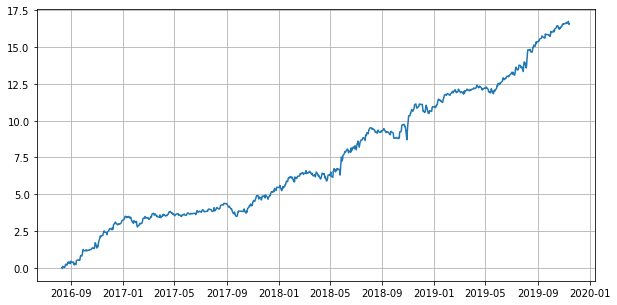

In [19]:
summary_pnl(portfolio_df, turn_over_df, price_s)

# **K-Means (K = 135)**

In [20]:
clusnum = a[3]
industry_list = ["cluster_"+str(i+1) for i in range(clusnum)]
industry_list

['cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9',
 'cluster_10',
 'cluster_11',
 'cluster_12',
 'cluster_13',
 'cluster_14',
 'cluster_15',
 'cluster_16',
 'cluster_17',
 'cluster_18',
 'cluster_19',
 'cluster_20',
 'cluster_21',
 'cluster_22',
 'cluster_23',
 'cluster_24',
 'cluster_25',
 'cluster_26',
 'cluster_27',
 'cluster_28',
 'cluster_29',
 'cluster_30',
 'cluster_31',
 'cluster_32',
 'cluster_33',
 'cluster_34',
 'cluster_35',
 'cluster_36',
 'cluster_37',
 'cluster_38',
 'cluster_39',
 'cluster_40',
 'cluster_41',
 'cluster_42',
 'cluster_43',
 'cluster_44',
 'cluster_45',
 'cluster_46',
 'cluster_47',
 'cluster_48',
 'cluster_49',
 'cluster_50',
 'cluster_51',
 'cluster_52',
 'cluster_53',
 'cluster_54',
 'cluster_55',
 'cluster_56',
 'cluster_57',
 'cluster_58',
 'cluster_59',
 'cluster_60',
 'cluster_61',
 'cluster_62',
 'cluster_63',
 'cluster_64',
 'cluster_65',
 'cluster_66',
 'cluster_67',
 'cl

In [21]:
industry_fg_kmeans_t = np.transpose(industry_fg.copy())
label_array = []
for i in range(len(price_s)):
    five_days = price_s.iloc[max(0, i-4):i+1].copy()
    five_days_divvar = divvar(five_days)
    five_days_t = np.transpose(five_days_divvar)
    five_days_fill = five_days_t.fillna(0)

    model = KMeans(n_clusters = clusnum, algorithm = 'auto')
    five_days_kmeans = model.fit(five_days_fill)
    y = five_days_kmeans.labels_
    label_y = []
    for j in range(len(y)):
        label_y.append("cluster_"+str(y[j]+1))
    
    label_array.append(label_y)
    print(str(i+1)+"th day labeling completed.")

n = 0

for col in industry_fg_kmeans_t.columns:
    industry_fg_kmeans_t[col] = label_array[n]
    n+=1

industry_fg_kmeans = np.transpose(industry_fg_kmeans_t)

industry_fg_kmeans

1th day labeling completed.
2th day labeling completed.
3th day labeling completed.
4th day labeling completed.
5th day labeling completed.
6th day labeling completed.
7th day labeling completed.
8th day labeling completed.
9th day labeling completed.
10th day labeling completed.
11th day labeling completed.
12th day labeling completed.
13th day labeling completed.
14th day labeling completed.
15th day labeling completed.
16th day labeling completed.
17th day labeling completed.
18th day labeling completed.
19th day labeling completed.
20th day labeling completed.
21th day labeling completed.
22th day labeling completed.
23th day labeling completed.
24th day labeling completed.
25th day labeling completed.
26th day labeling completed.
27th day labeling completed.
28th day labeling completed.
29th day labeling completed.
30th day labeling completed.
31th day labeling completed.
32th day labeling completed.
33th day labeling completed.
34th day labeling completed.
35th day labeling compl

,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490,A051900,A017670,A028260,A105560,A034730,A015760,A000270,A006400,A018260,A032830,A096770,A035720,A033780,A003550,A066570,A036570,A000810,A086790,A090430,A010950,A009540,A316140,A009150,A010130,A251270,A011170,A091990,A030200,A021240,A024110,...,A223040,A225440,A225650,A226330,A226850,A230490,A232270,A232330,A235010,A235980,A240540,A257730,A262830,A278650,A288330,A290510,A322510,A327260,A335870,A335890,A336060,A336570,A337450,A338100,A340120,A340360,A900010,A900020,A900030,A900050,A900060,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950190
2016-08-10,cluster_131,cluster_74,cluster_104,cluster_30,cluster_14,cluster_117,cluster_19,cluster_33,cluster_56,cluster_40,cluster_77,cluster_40,cluster_128,cluster_40,cluster_30,cluster_124,cluster_7,cluster_85,cluster_28,cluster_79,cluster_79,cluster_40,cluster_114,cluster_76,cluster_56,cluster_124,cluster_14,cluster_126,cluster_54,cluster_122,cluster_106,cluster_14,cluster_18,cluster_117,cluster_14,cluster_117,cluster_14,cluster_12,cluster_33,cluster_12,...,cluster_79,cluster_14,cluster_14,cluster_14,cluster_40,cluster_40,cluster_14,cluster_14,cluster_1,cluster_14,cluster_57,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_2,cluster_14,cluster_135,cluster_34,cluster_14,cluster_115,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14
2016-08-11,cluster_1,cluster_67,cluster_92,cluster_117,cluster_67,cluster_1,cluster_126,cluster_126,cluster_135,cluster_113,cluster_92,cluster_1,cluster_1,cluster_58,cluster_117,cluster_126,cluster_1,cluster_73,cluster_89,cluster_92,cluster_126,cluster_113,cluster_126,cluster_1,cluster_120,cluster_126,cluster_100,cluster_126,cluster_92,cluster_29,cluster_1,cluster_67,cluster_117,cluster_1,cluster_67,cluster_39,cluster_67,cluster_1,cluster_110,cluster_91,...,cluster_126,cluster_67,cluster_51,cluster_67,cluster_105,cluster_129,cluster_125,cluster_67,cluster_97,cluster_67,cluster_74,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_126,cluster_84,cluster_67,cluster_126,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67
2016-08-12,cluster_1,cluster_1,cluster_56,cluster_108,cluster_26,cluster_79,cluster_93,cluster_106,cluster_89,cluster_40,cluster_56,cluster_31,cluster_31,cluster_33,cluster_108,cluster_14,cluster_108,cluster_121,cluster_12,cluster_14,cluster_93,cluster_52,cluster_113,cluster_31,cluster_33,cluster_106,cluster_35,cluster_61,cluster_14,cluster_44,cluster_108,cluster_26,cluster_79,cluster_41,cluster_26,cluster_19,cluster_26,cluster_31,cluster_81,cluster_40,...,cluster_106,cluster_26,cluster_122,cluster_26,cluster_97,cluster_66,cluster_134,cluster_26,cluster_39,cluster_26,cluster_92,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_14,cluster_26,cluster_93,cluster_85,cluster_26,cluster_106,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26
2016-08-16,cluster_52,cluster_52,cluster_70,cluster_34,cluster_1,cluster_51,cluster_14,cluster_135,cluster_128,cluster_130,cluster_14,cluster_26,cluster_26,cluster_53,cluster_93,cluster_94,cluster_66,cluster_77,cluster_135,cluster_94,cluster_73,cluster_35,cluster_73,cluster_128,cluster_56,cluster_135,cluster_8,cluster_63,cluster_14,cluster_56,cluster_130,cluster_1,cluster_93,cluster_51,cluster_1,cluster_116,cluster_1,cluster_26,cluster_66,cluster_130,...,cluster_135,cluster_21,cluster_85,cluster_1,cluster_83,cluster_62,cluster_69,cluster_1,cluster_38,cluster_1,cluster_122,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster

In [22]:
c = industry_fg_kmeans.copy()
c

,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490,A051900,A017670,A028260,A105560,A034730,A015760,A000270,A006400,A018260,A032830,A096770,A035720,A033780,A003550,A066570,A036570,A000810,A086790,A090430,A010950,A009540,A316140,A009150,A010130,A251270,A011170,A091990,A030200,A021240,A024110,...,A223040,A225440,A225650,A226330,A226850,A230490,A232270,A232330,A235010,A235980,A240540,A257730,A262830,A278650,A288330,A290510,A322510,A327260,A335870,A335890,A336060,A336570,A337450,A338100,A340120,A340360,A900010,A900020,A900030,A900050,A900060,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950190
2016-08-10,cluster_131,cluster_74,cluster_104,cluster_30,cluster_14,cluster_117,cluster_19,cluster_33,cluster_56,cluster_40,cluster_77,cluster_40,cluster_128,cluster_40,cluster_30,cluster_124,cluster_7,cluster_85,cluster_28,cluster_79,cluster_79,cluster_40,cluster_114,cluster_76,cluster_56,cluster_124,cluster_14,cluster_126,cluster_54,cluster_122,cluster_106,cluster_14,cluster_18,cluster_117,cluster_14,cluster_117,cluster_14,cluster_12,cluster_33,cluster_12,...,cluster_79,cluster_14,cluster_14,cluster_14,cluster_40,cluster_40,cluster_14,cluster_14,cluster_1,cluster_14,cluster_57,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14,cluster_2,cluster_14,cluster_135,cluster_34,cluster_14,cluster_115,cluster_14,cluster_14,cluster_14,cluster_14,cluster_14
2016-08-11,cluster_1,cluster_67,cluster_92,cluster_117,cluster_67,cluster_1,cluster_126,cluster_126,cluster_135,cluster_113,cluster_92,cluster_1,cluster_1,cluster_58,cluster_117,cluster_126,cluster_1,cluster_73,cluster_89,cluster_92,cluster_126,cluster_113,cluster_126,cluster_1,cluster_120,cluster_126,cluster_100,cluster_126,cluster_92,cluster_29,cluster_1,cluster_67,cluster_117,cluster_1,cluster_67,cluster_39,cluster_67,cluster_1,cluster_110,cluster_91,...,cluster_126,cluster_67,cluster_51,cluster_67,cluster_105,cluster_129,cluster_125,cluster_67,cluster_97,cluster_67,cluster_74,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67,cluster_126,cluster_84,cluster_67,cluster_126,cluster_67,cluster_67,cluster_67,cluster_67,cluster_67
2016-08-12,cluster_1,cluster_1,cluster_56,cluster_108,cluster_26,cluster_79,cluster_93,cluster_106,cluster_89,cluster_40,cluster_56,cluster_31,cluster_31,cluster_33,cluster_108,cluster_14,cluster_108,cluster_121,cluster_12,cluster_14,cluster_93,cluster_52,cluster_113,cluster_31,cluster_33,cluster_106,cluster_35,cluster_61,cluster_14,cluster_44,cluster_108,cluster_26,cluster_79,cluster_41,cluster_26,cluster_19,cluster_26,cluster_31,cluster_81,cluster_40,...,cluster_106,cluster_26,cluster_122,cluster_26,cluster_97,cluster_66,cluster_134,cluster_26,cluster_39,cluster_26,cluster_92,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26,cluster_14,cluster_26,cluster_93,cluster_85,cluster_26,cluster_106,cluster_26,cluster_26,cluster_26,cluster_26,cluster_26
2016-08-16,cluster_52,cluster_52,cluster_70,cluster_34,cluster_1,cluster_51,cluster_14,cluster_135,cluster_128,cluster_130,cluster_14,cluster_26,cluster_26,cluster_53,cluster_93,cluster_94,cluster_66,cluster_77,cluster_135,cluster_94,cluster_73,cluster_35,cluster_73,cluster_128,cluster_56,cluster_135,cluster_8,cluster_63,cluster_14,cluster_56,cluster_130,cluster_1,cluster_93,cluster_51,cluster_1,cluster_116,cluster_1,cluster_26,cluster_66,cluster_130,...,cluster_135,cluster_21,cluster_85,cluster_1,cluster_83,cluster_62,cluster_69,cluster_1,cluster_38,cluster_1,cluster_122,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster

In [0]:
industry_dic = make_loading_matrix(industry_list, industry_fg_kmeans)

In [24]:
industry_dic[industry_list[130]]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [25]:
signal = price_s.rolling(5, min_periods=1).mean()
portfolio_df,turn_over_df = mean_reversion(signal, industry_list, industry_dic)

cluster_1
cluster_2
cluster_3
cluster_4
cluster_5
cluster_6
cluster_7
cluster_8
cluster_9
cluster_10
cluster_11
cluster_12
cluster_13
cluster_14
cluster_15
cluster_16
cluster_17
cluster_18
cluster_19
cluster_20
cluster_21
cluster_22
cluster_23
cluster_24
cluster_25
cluster_26
cluster_27
cluster_28
cluster_29
cluster_30
cluster_31
cluster_32
cluster_33
cluster_34
cluster_35
cluster_36
cluster_37
cluster_38
cluster_39
cluster_40
cluster_41
cluster_42
cluster_43
cluster_44
cluster_45
cluster_46
cluster_47
cluster_48
cluster_49
cluster_50
cluster_51
cluster_52
cluster_53
cluster_54
cluster_55
cluster_56
cluster_57
cluster_58
cluster_59
cluster_60
cluster_61
cluster_62
cluster_63
cluster_64
cluster_65
cluster_66
cluster_67
cluster_68
cluster_69
cluster_70
cluster_71
cluster_72
cluster_73
cluster_74
cluster_75
cluster_76
cluster_77
cluster_78
cluster_79
cluster_80
cluster_81
cluster_82
cluster_83
cluster_84
cluster_85
cluster_86
cluster_87
cluster_88
cluster_89
cluster_90
cluster_91
cluster_

,Sharp_ratio,Profit and Loss(%),Turn_over_rate(%)
2016-12-31,4.535164,6.222169,43.397896
2017-12-31,1.353516,1.681595,45.798260
2018-12-31,2.064894,4.239277,45.366317
2019-12-31,3.412493,4.858149,46.414435


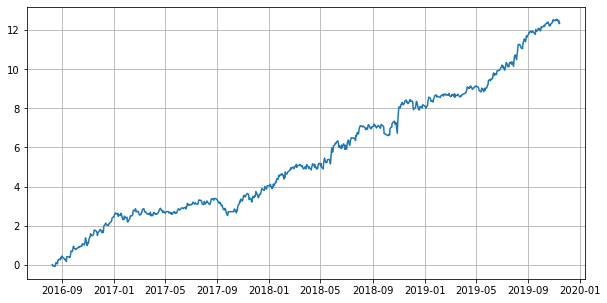

In [26]:
summary_pnl(portfolio_df, turn_over_df, price_s)

# **K-Means (K = 26)**

In [27]:
clusnum = a[4]
industry_list = ["cluster_"+str(i+1) for i in range(clusnum)]
industry_list

['cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9',
 'cluster_10',
 'cluster_11',
 'cluster_12',
 'cluster_13',
 'cluster_14',
 'cluster_15',
 'cluster_16',
 'cluster_17',
 'cluster_18',
 'cluster_19',
 'cluster_20',
 'cluster_21',
 'cluster_22',
 'cluster_23']

In [28]:
industry_fg_kmeans_t = np.transpose(industry_fg.copy())
label_array = []
for i in range(len(price_s)):
    five_days = price_s.iloc[max(0, i-4):i+1].copy()
    five_days_divvar = divvar(five_days)
    five_days_t = np.transpose(five_days_divvar)
    five_days_fill = five_days_t.fillna(0)

    model = KMeans(n_clusters = clusnum, algorithm = 'auto')
    five_days_kmeans = model.fit(five_days_fill)
    y = five_days_kmeans.labels_
    label_y = []
    for j in range(len(y)):
        label_y.append("cluster_"+str(y[j]+1))
    
    label_array.append(label_y)
    print(str(i+1)+"th day labeling completed.")

n = 0

for col in industry_fg_kmeans_t.columns:
    industry_fg_kmeans_t[col] = label_array[n]
    n+=1

industry_fg_kmeans = np.transpose(industry_fg_kmeans_t)

industry_fg_kmeans

1th day labeling completed.
2th day labeling completed.
3th day labeling completed.
4th day labeling completed.
5th day labeling completed.
6th day labeling completed.
7th day labeling completed.
8th day labeling completed.
9th day labeling completed.
10th day labeling completed.
11th day labeling completed.
12th day labeling completed.
13th day labeling completed.
14th day labeling completed.
15th day labeling completed.
16th day labeling completed.
17th day labeling completed.
18th day labeling completed.
19th day labeling completed.
20th day labeling completed.
21th day labeling completed.
22th day labeling completed.
23th day labeling completed.
24th day labeling completed.
25th day labeling completed.
26th day labeling completed.
27th day labeling completed.
28th day labeling completed.
29th day labeling completed.
30th day labeling completed.
31th day labeling completed.
32th day labeling completed.
33th day labeling completed.
34th day labeling completed.
35th day labeling compl

,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490,A051900,A017670,A028260,A105560,A034730,A015760,A000270,A006400,A018260,A032830,A096770,A035720,A033780,A003550,A066570,A036570,A000810,A086790,A090430,A010950,A009540,A316140,A009150,A010130,A251270,A011170,A091990,A030200,A021240,A024110,...,A223040,A225440,A225650,A226330,A226850,A230490,A232270,A232330,A235010,A235980,A240540,A257730,A262830,A278650,A288330,A290510,A322510,A327260,A335870,A335890,A336060,A336570,A337450,A338100,A340120,A340360,A900010,A900020,A900030,A900050,A900060,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950190
2016-08-10,cluster_1,cluster_16,cluster_5,cluster_1,cluster_2,cluster_13,cluster_11,cluster_19,cluster_13,cluster_20,cluster_19,cluster_20,cluster_20,cluster_20,cluster_1,cluster_5,cluster_13,cluster_22,cluster_17,cluster_22,cluster_22,cluster_20,cluster_9,cluster_20,cluster_13,cluster_5,cluster_2,cluster_9,cluster_11,cluster_13,cluster_1,cluster_2,cluster_1,cluster_13,cluster_2,cluster_13,cluster_2,cluster_20,cluster_19,cluster_20,...,cluster_22,cluster_2,cluster_2,cluster_2,cluster_20,cluster_20,cluster_2,cluster_2,cluster_2,cluster_2,cluster_13,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_8,cluster_2,cluster_5,cluster_9,cluster_2,cluster_22,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2
2016-08-11,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_22,cluster_1,cluster_1,cluster_1,cluster_1,...,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1
2016-08-12,cluster_1,cluster_1,cluster_21,cluster_1,cluster_1,cluster_23,cluster_1,cluster_21,cluster_23,cluster_21,cluster_21,cluster_1,cluster_1,cluster_13,cluster_1,cluster_1,cluster_1,cluster_1,cluster_21,cluster_1,cluster_21,cluster_17,cluster_21,cluster_23,cluster_13,cluster_21,cluster_1,cluster_21,cluster_1,cluster_7,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_21,cluster_1,cluster_23,cluster_20,cluster_1,...,cluster_21,cluster_1,cluster_21,cluster_1,cluster_23,cluster_23,cluster_18,cluster_1,cluster_20,cluster_1,cluster_17,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_21,cluster_1,cluster_1,cluster_21,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1
2016-08-16,cluster_1,cluster_1,cluster_21,cluster_17,cluster_1,cluster_17,cluster_1,cluster_1,cluster_17,cluster_15,cluster_12,cluster_1,cluster_1,cluster_19,cluster_17,cluster_1,cluster_17,cluster_12,cluster_12,cluster_1,cluster_15,cluster_16,cluster_1,cluster_17,cluster_20,cluster_15,cluster_12,cluster_15,cluster_1,cluster_20,cluster_17,cluster_1,cluster_17,cluster_12,cluster_1,cluster_10,cluster_1,cluster_13,cluster_1,cluster_1,...,cluster_1,cluster_22,cluster_7,cluster_1,cluster_10,cluster_13,cluster_8,cluster_1,cluster_23,cluster_1,cluster_20,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_21,cluster_15,cluster_1,cluster_15,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1
2016-

In [29]:
d = industry_fg_kmeans.copy()
d

,A005930,A000660,A035420,A005380,A207940,A012330,A068270,A051910,A055550,A005490,A051900,A017670,A028260,A105560,A034730,A015760,A000270,A006400,A018260,A032830,A096770,A035720,A033780,A003550,A066570,A036570,A000810,A086790,A090430,A010950,A009540,A316140,A009150,A010130,A251270,A011170,A091990,A030200,A021240,A024110,...,A223040,A225440,A225650,A226330,A226850,A230490,A232270,A232330,A235010,A235980,A240540,A257730,A262830,A278650,A288330,A290510,A322510,A327260,A335870,A335890,A336060,A336570,A337450,A338100,A340120,A340360,A900010,A900020,A900030,A900050,A900060,A900090,A900130,A900150,A900180,A950010,A950030,A950070,A950100,A950190
2016-08-10,cluster_1,cluster_16,cluster_5,cluster_1,cluster_2,cluster_13,cluster_11,cluster_19,cluster_13,cluster_20,cluster_19,cluster_20,cluster_20,cluster_20,cluster_1,cluster_5,cluster_13,cluster_22,cluster_17,cluster_22,cluster_22,cluster_20,cluster_9,cluster_20,cluster_13,cluster_5,cluster_2,cluster_9,cluster_11,cluster_13,cluster_1,cluster_2,cluster_1,cluster_13,cluster_2,cluster_13,cluster_2,cluster_20,cluster_19,cluster_20,...,cluster_22,cluster_2,cluster_2,cluster_2,cluster_20,cluster_20,cluster_2,cluster_2,cluster_2,cluster_2,cluster_13,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2,cluster_8,cluster_2,cluster_5,cluster_9,cluster_2,cluster_22,cluster_2,cluster_2,cluster_2,cluster_2,cluster_2
2016-08-11,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_22,cluster_1,cluster_1,cluster_1,cluster_1,...,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1
2016-08-12,cluster_1,cluster_1,cluster_21,cluster_1,cluster_1,cluster_23,cluster_1,cluster_21,cluster_23,cluster_21,cluster_21,cluster_1,cluster_1,cluster_13,cluster_1,cluster_1,cluster_1,cluster_1,cluster_21,cluster_1,cluster_21,cluster_17,cluster_21,cluster_23,cluster_13,cluster_21,cluster_1,cluster_21,cluster_1,cluster_7,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_21,cluster_1,cluster_23,cluster_20,cluster_1,...,cluster_21,cluster_1,cluster_21,cluster_1,cluster_23,cluster_23,cluster_18,cluster_1,cluster_20,cluster_1,cluster_17,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_21,cluster_1,cluster_1,cluster_21,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1
2016-08-16,cluster_1,cluster_1,cluster_21,cluster_17,cluster_1,cluster_17,cluster_1,cluster_1,cluster_17,cluster_15,cluster_12,cluster_1,cluster_1,cluster_19,cluster_17,cluster_1,cluster_17,cluster_12,cluster_12,cluster_1,cluster_15,cluster_16,cluster_1,cluster_17,cluster_20,cluster_15,cluster_12,cluster_15,cluster_1,cluster_20,cluster_17,cluster_1,cluster_17,cluster_12,cluster_1,cluster_10,cluster_1,cluster_13,cluster_1,cluster_1,...,cluster_1,cluster_22,cluster_7,cluster_1,cluster_10,cluster_13,cluster_8,cluster_1,cluster_23,cluster_1,cluster_20,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1,cluster_21,cluster_15,cluster_1,cluster_15,cluster_1,cluster_1,cluster_1,cluster_1,cluster_1
2016-

In [0]:
industry_dic = make_loading_matrix(industry_list, industry_fg_kmeans)

In [31]:
industry_dic[industry_list[0]]

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]])

In [32]:
signal = price_s.rolling(5, min_periods=1).mean()
portfolio_df,turn_over_df = mean_reversion(signal, industry_list, industry_dic)

cluster_1
cluster_2
cluster_3
cluster_4
cluster_5
cluster_6
cluster_7
cluster_8
cluster_9
cluster_10
cluster_11
cluster_12
cluster_13
cluster_14
cluster_15
cluster_16
cluster_17
cluster_18
cluster_19
cluster_20
cluster_21
cluster_22
cluster_23


,Sharp_ratio,Profit and Loss(%),Turn_over_rate(%)
2016-12-31,4.391572,7.675409,34.654535
2017-12-31,1.746791,2.657883,36.477169
2018-12-31,2.178420,6.624826,35.587690
2019-12-31,4.373664,8.501567,36.629375


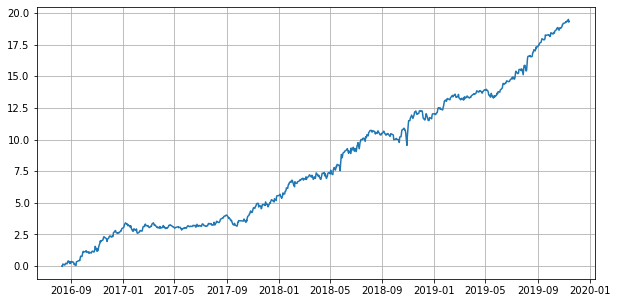

In [33]:
summary_pnl(portfolio_df, turn_over_df, price_s)